In [60]:
# Import necessary libraries
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPTokenizer, CLIPModel
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn



# Initialize CLIP processor and tokenizer
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Current device:', device)

Current device: cuda


In [54]:
class CaptionDataset(Dataset):
    def __init__(self, dataset, clip_model_name="openai/clip-vit-base-patch32", device=device):
        self.image = dataset['image']
        self.caption_list = dataset['caption']
        
        self.device = device

        self.processor = CLIPProcessor.from_pretrained(clip_model_name)
        self.tokenizer = CLIPTokenizer.from_pretrained(clip_model_name)
        self.clip_model = CLIPModel.from_pretrained(clip_model_name).eval().to(self.device)

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        image = self.image[idx]
        caption_list = self.caption_list[idx]
        
        # ---- Encode image with CLIP ----
        img_tensor = self.processor(images=image, return_tensors="pt").to(self.device)
        #print('IMG TENSOR SHAPE', img_tensor.shape) # channels, height, width
        
        # ---- Tokenize input caption ----
        caption = caption_list[0] # get the first caption in the list
        #print('caption len:', len(caption))
        tokens = self.tokenizer(caption, padding="max_length", max_length=32, return_tensors="pt", truncation=True)

        input_ids_full = tokens["input_ids"].to(self.device)  # [1, seq_len]
        #print('text_input_ids_full shape:', input_ids_full.shape)
        mask = tokens["attention_mask"].to(self.device) # get the mask out

        with torch.no_grad():
            # Use only embedding layer from CLIP
            text_embeddings = self.clip_model.text_model.embeddings(input_ids_full).squeeze(0).to(self.device)

            # Get the CLIP encoded image embeddings
            patch_embeddings = self.clip_model.vision_model(**img_tensor).last_hidden_state[:, 1:, :].squeeze(0).to(self.device) # shape: [1, num_patches, hidden_dim]
            #print('Patch embeddings shape:', patch_embeddings.shape)           
            
            
        target_ids = input_ids_full.squeeze(0).to(self.device)

        #print('IMG EMBEDDINGS SHAPE', patch_embeddings.shape)
        #print('TEXT EMBEDDINGS SHAPE', text_embeddings.shape)
        #print('TARGET IDS SHAPE', target_ids.shape)
        #print('MASK SHAPE', mask.shape)

        return patch_embeddings, text_embeddings, target_ids, mask
            


# create the image captioning model

⬆️ The code above projects the text and image embeddings into the same shape so now we can send it! 

In [78]:
# Create Masked Self Attention Head
class MaskedAttentionHead(nn.Module):
    def __init__(self, embedding_dim, head_dim):
        super(MaskedAttentionHead, self).__init__()
        self.head_dim = head_dim

        # Linear projections for query, key, value
        self.weight_q = nn.Linear(embedding_dim, head_dim)
        self.weight_k = nn.Linear(embedding_dim, head_dim)
        self.weight_v = nn.Linear(embedding_dim, head_dim)

        self.linear_projection = nn.Linear(head_dim, embedding_dim)

    def forward(self, decoder_sequence, input_sequence_length, padding_mask=None, ):
        # embedded decoder sequence shape: [batch_size, seq_length, embedding_dim]

        #print('Decoder sequence shape:', decoder_sequence.shape)

        # Project to head dimension
        Q = self.weight_q(decoder_sequence)
        K = self.weight_k(decoder_sequence)
        V = self.weight_v(decoder_sequence)

        # Make the mask
        decoder_sequence_length = decoder_sequence.shape[1]
        mask = torch.triu(torch.ones(decoder_sequence_length, decoder_sequence_length, device=decoder_sequence.device), diagonal=1)
        #print("Causal mask shape:", mask.shape)
        mask = mask.masked_fill(mask==1, float('-inf'))

        # Calculate attention scores (scaled dot product)
        A = torch.einsum('bid,bjd->bij', Q, K)
        A = A / (self.head_dim ** 0.5) 

        A = A + mask

        
        # Apply padding mask if provided
        #if padding_mask is not None:
            #print('Padding mask shape:', padding_mask.shape)
            # Convert padding mask to attention mask
        #    padding_mask = padding_mask.expand(-1, A.size(1), -1)
        #    A = A.masked_fill(padding_mask, float('-inf'))
            
        # Apply softmax
        A = torch.softmax(A, dim=-1)

    
        #  Apply attention weights to values
        H = torch.einsum('bij,bjd->bid', A, V)
        
        # Add projection layer for output to return back to the original embedding dimension
        #output = self.linear_projection(H)

        return H

### MODEL

In [70]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.head_dim = embedding_dim // num_heads

     
        self.heads = nn.ModuleList(
            [MaskedAttentionHead(embedding_dim, self.head_dim) for _ in range(num_heads)]
            )
        
        # The output of the CrossAttention Head and MaskedAttentionHead still needs to be projected
        # Back to the embedding dimensions of the head_dim x vocab_size
        
        self.output_projection = nn.Linear(num_heads * self.head_dim, embedding_dim)

        

    def forward(self, decoder_sequence, padding_mask=None):
        # decoder_sequence: [batch_size, seq_length, embedding_dim]
        # encoder_output: [batch_size, num_patches, embedding_dim] (only used in cross-attention)
        # mask: [batch_size, seq_length, seq_length] (only used in self-attention)

        # Process each head
        head_outputs = []
        for head in self.heads:
                # For masked self-attention, we only need decoder sequence and mask
                head_output = head(decoder_sequence, padding_mask)
                #print("\nmasked attention head output shape: ", head_output.shape)
                
                head_outputs.append(head_output)

        # Concatenate head outputs
        concat_heads = torch.cat(head_outputs, dim=-1)
        
        # Project back to embedding dimension
        output = self.output_projection(concat_heads)
        #print("Multihead attention output shape: ", output.shape)
        
        return output



In [71]:
class DecoderBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads, mlp_dimension):
        super(DecoderBlock, self).__init__()
        
        # First layer norm
        self.ln1 = nn.LayerNorm(embedding_dim)
        
        # Masked multi-head attention for decoder sequence self-attention
        self.masked_mha = MultiHeadAttention(embedding_dim, num_heads)
        
        
        # Third layer norm
        self.ln2 = nn.LayerNorm(embedding_dim)
        
        # Feed forward network
        self.ffn = nn.Sequential(
            nn.Linear(embedding_dim, mlp_dimension),
            nn.ReLU(),
            nn.Linear(mlp_dimension, embedding_dim)
        )

    def forward(self, decoder_sequence, padding_mask=None):
        # decoder_sequence: the input sequence to decode (e.g., [START, 1, 2, 3])
        # encoder_output: the encoded image from the encoder
        # mask: causal mask to prevent attending to future tokens

        # First masked self-attention block with residual connection
        # This allows decoder sequence to attend to its own past tokens
        # First masked self-attention
        residual = decoder_sequence
        decoder_sequence = self.ln1(decoder_sequence)
        decoder_sequence = self.masked_mha(decoder_sequence, padding_mask)
        decoder_sequence = residual + decoder_sequence

        
        # # FFN block with residual connection
        residual = decoder_sequence
        decoder_sequence = self.ln2(decoder_sequence)
        decoder_sequence = self.ffn(decoder_sequence)
        decoder_sequence = residual + decoder_sequence
        
        return decoder_sequence



In [76]:
class Decoder(nn.Module):
    def __init__(self, embedding_dim, num_heads, mlp_dimension, num_layers, vocab_size):
        super(Decoder, self).__init__()
        
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
    
        # Create positional embeddings for decoder sequence ONCE during initialization
        #self.positional_embeddings = nn.Parameter(
        #    torch.randn(1, 1, embedding_dim), # 81 because its 32 caption len + 49 patches
        #    requires_grad=True
       # )
        
        # Create decoder blocks
        self.decoder_blocks = nn.ModuleList([
            DecoderBlock(embedding_dim, num_heads, mlp_dimension)
            for _ in range(num_layers)
        ])
        
        # Final layer norm
        self.final_ln = nn.LayerNorm(embedding_dim)

        # Output projection to vocabulary size
        # This converts decoder features to logits over possible next tokensß
        self.output_projection = nn.Linear(embedding_dim, vocab_size)

    def forward(self, text_embeddings, img_features, padding_mask=None, return_logits=True):
        # return_logits: whether to return prediction logits or just decoder features
        # by default, we return logits

        # Add positional embeddings to decoder sequence
        #decoder_sequence = embedded_decoder_sequence + self.positional_embeddings
        
        # Concatenate image features and text embeddings
        decoder_inputs = torch.cat([img_features, text_embeddings], dim=1).to(device)
        #print('Decoder inputs shape:', decoder_inputs.shape)
        
        # Add new positional embeddings
        #decoder_inputs = decoder_inputs + self.positional_embeddings

        # Pass through decoder blocks
        for block in self.decoder_blocks:
            decoder_inputs = block(decoder_inputs, padding_mask)
        
        # Apply final layer norm
        decoder_features = self.final_ln(decoder_inputs)

        # Get text hidden states only
        text_hidden = decoder_features[:, -32:, :]
        
        if return_logits:
            # Convert features to logits for prediction
            # Shape: [batch_size, seq_length, vocab_size]
            logits = self.output_projection(text_hidden)
            return logits
        else:
            # Return decoder features if needed
            return text_hidden

### MODEL

In [73]:
# load dataset and create train and test sets
raw_dataset = load_dataset("nlphuji/flickr30k", split='test[:5000]')

# Split the dataset into training and testing sets
train_test_split = raw_dataset.train_test_split(test_size=0.3)
train = train_test_split['train']
test = train_test_split['test']

print(test)
print(train)

test_caption = CaptionDataset(test)
train_caption = CaptionDataset(train)

# Create a DataLoader
test_dataloader = DataLoader(test_caption, batch_size=10, shuffle=False)  # Adjust batch_size as needed
train_dataloader = DataLoader(train_caption, batch_size=10, shuffle=False)


Dataset({
    features: ['image', 'caption', 'sentids', 'split', 'img_id', 'filename'],
    num_rows: 1500
})
Dataset({
    features: ['image', 'caption', 'sentids', 'split', 'img_id', 'filename'],
    num_rows: 3500
})


### MODEL

In [77]:
import torch.optim as optim
from tqdm import tqdm

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Parameters for decoder
embedding_dim = 512
num_heads = 8
mlp_dimension = 2048
num_layers = 6
input_sequence_length = 32
vocab_size = 49408

decoder = Decoder(embedding_dim=embedding_dim, num_heads=num_heads, 
                  mlp_dimension=mlp_dimension, num_layers=num_layers, 
                  vocab_size=vocab_size).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(decoder.parameters(), lr=1e-4)

# Move projection layer to device
image_projection_layer = nn.Linear(768, embedding_dim).to(device)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):

    decoder.train()

    # Training phase
    train_pbar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', mininterval=0.1)

    epoch_losses = [] # store all individual losses and calculate the true average at the end

    # Iterate over the DataLoader and print the outputs
    for batch_idx, (patch_embeddings, text_embeddings, target_ids, mask) in enumerate(train_pbar):

        # Move everything to device
        patch_embeddings = patch_embeddings.to(device)
        text_embeddings = text_embeddings.to(device)
        mask = mask.to(device)
        targets = target_ids.to(device)
        img_features = image_projection_layer(patch_embeddings)

    
        #print('\nProjected img shape:', img_features.shape)
        #print('Projected text shape:', text_embeddings.shape)

        #print('Mask shape:', mask.shape)


        text_embeddings = text_embeddings.to(device)
        img_features = img_features.to(device)
        targets = target_ids.to(device)

        # Forward pass through the decoder
        logits = decoder(text_embeddings, img_features)

        #print('logits shape:', logits.shape)

        # Compute loss
        # Shift logits and targets to align for cross-entropy
        logits = logits[:, :-1].contiguous().view(-1, logits.size(-1))
        targets = target_ids[:, 1:].contiguous().view(-1)
        loss = criterion(logits, targets)

        # Calculate loss only on text portion
        #text_logits = logits[:, -32:, :] # Shape: [batch_size, 32, vocab_size]
        #print('text_logits shape:', text_logits.shape)

        # Sqeuueze mask to remove th eextra dimension
        #mask=mask.squeeze(1)
        #print('mask shape:', mask.shape)

        # Apply teacher forcing to text portion only 
        #text_logits = text_logits[:, :-1].contiguous().view(-1, text_logits.size(-1))
        #text_targets = target_ids[:, 1:].contiguous().view(-1)
        #text_mask = mask[:, 1:].contiguous().view(-1)

        #print('text_logits shape:', text_logits.shape)
        #print('text_targets shape:', text_targets.shape)
       
        # Calculate loss only on masked positions
        #text_mask = text_mask.bool()
        #loss = criterion(
        #    text_logits[text_mask],
        #    text_targets[text_mask]
        #)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # Store the loss for this batch
        epoch_losses.append(loss.item())
        
        # Update progress bar with current batch loss
        train_pbar.set_postfix({
            'batch_loss': f'{loss.item():.4f}'
        })
        train_pbar.update(1)

    # Close progress bar for this epoch
    train_pbar.close()
    
    # Print epoch summary
    # Calculate and print training epoch average loss
    avg_train_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")
    print(" ")

     # Validation phase
    decoder.eval()  # Set model to evaluation mode
    val_losses = []  # Store all validation losses
    
    with torch.no_grad():  # Disable gradient calculation for validation
        val_pbar = tqdm(test_dataloader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]', mininterval=0.1)
        
        for batch_idx, (patch_embeddings, text_embeddings, target_ids, mask) in enumerate(val_pbar):

            # Move everything to device
            patch_embeddings = patch_embeddings.to(device)
            text_embeddings = text_embeddings.to(device)
            mask = mask.to(device)
            targets = target_ids.to(device)
            img_features = image_projection_layer(patch_embeddings)


            # Forward pass through the decoder
            logits = decoder(text_embeddings, img_features)

            # Compute loss
            # Shift logits and targets to align for cross-entropy
            logits = logits[:, :-1].contiguous().view(-1, logits.size(-1))
            targets = target_ids[:, 1:].contiguous().view(-1)
            val_loss = criterion(logits, targets)

            # Calculate loss only on text portion
            #text_logits = logits[:, -32:, :] # Shape: [batch_size, 32, vocab_size]
            #print('text_logits shape:', text_logits.shape)

            # Sqeuueze mask to remove th eextra dimension
            #mask=mask.squeeze(1)
            #print('mask shape:', mask.shape)

            # Apply teacher forcing to text portion only 
            #text_logits = text_logits[:, :-1].contiguous().view(-1, text_logits.size(-1))
            #text_targets = target_ids[:, 1:].contiguous().view(-1)
            #text_mask = mask[:, 1:].contiguous().view(-1)

            #print('text_logits shape:', text_logits.shape)
            #print('text_targets shape:', text_targets.shape)
        

            # Calculate loss only on masked positions
            #text_mask = text_mask.bool()
            #val_loss = criterion(
            #    text_logits[text_mask],
            #    text_targets[text_mask]
            #)

            # Store validation loss
            val_losses.append(val_loss.item())
            
            # Update progress bar with current validation loss
            val_pbar.set_postfix({
                'val_loss': f'{val_loss.item():.4f}'
            })
            val_pbar.update(1)
    
    # Close validation progress bar
    val_pbar.close()
    
    # Calculate average validation loss
    avg_val_loss = sum(val_losses) / len(val_losses)
    
    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} Val Loss: {avg_val_loss:.4f}")

        
print("Training complete.")



Epoch 1/10 [Train]: 100%|██████████| 350/350 [01:01<00:00,  5.70it/s, batch_loss=5.0161]


Epoch 1/10, Train Loss: 5.7060
 


Epoch 1/10 [Val]: 100%|██████████| 150/150 [00:19<00:00,  7.70it/s, val_loss=5.4466]


Epoch 1/10 Val Loss: 4.8038


Epoch 2/10 [Train]: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s, batch_loss=4.6123]


Epoch 2/10, Train Loss: 4.4309
 


Epoch 2/10 [Val]: 100%|██████████| 150/150 [00:19<00:00,  7.70it/s, val_loss=5.1072]


Epoch 2/10 Val Loss: 4.4843


Epoch 3/10 [Train]: 100%|██████████| 350/350 [01:02<00:00,  5.60it/s, batch_loss=4.3042]


Epoch 3/10, Train Loss: 4.0390
 


Epoch 3/10 [Val]: 100%|██████████| 150/150 [00:19<00:00,  7.83it/s, val_loss=4.9042]


Epoch 3/10 Val Loss: 4.3087


Epoch 4/10 [Train]: 100%|██████████| 350/350 [01:03<00:00,  5.50it/s, batch_loss=3.9959]


Epoch 4/10, Train Loss: 3.7095
 


Epoch 4/10 [Val]: 100%|██████████| 150/150 [00:19<00:00,  7.53it/s, val_loss=4.7753]


Epoch 4/10 Val Loss: 4.2082


Epoch 5/10 [Train]: 100%|██████████| 350/350 [01:03<00:00,  5.51it/s, batch_loss=3.6468]


Epoch 5/10, Train Loss: 3.3733
 


Epoch 5/10 [Val]: 100%|██████████| 150/150 [00:20<00:00,  7.42it/s, val_loss=4.7315]


Epoch 5/10 Val Loss: 4.1702


Epoch 6/10 [Train]: 100%|██████████| 350/350 [01:02<00:00,  5.58it/s, batch_loss=3.2176]


Epoch 6/10, Train Loss: 3.0034
 


Epoch 6/10 [Val]: 100%|██████████| 150/150 [00:19<00:00,  7.77it/s, val_loss=4.8324]


Epoch 6/10 Val Loss: 4.1917


Epoch 7/10 [Train]: 100%|██████████| 350/350 [01:01<00:00,  5.67it/s, batch_loss=2.8657]


Epoch 7/10, Train Loss: 2.6395
 


Epoch 7/10 [Val]: 100%|██████████| 150/150 [00:19<00:00,  7.69it/s, val_loss=4.8966]


Epoch 7/10 Val Loss: 4.2392


Epoch 8/10 [Train]: 100%|██████████| 350/350 [01:02<00:00,  5.63it/s, batch_loss=2.5527]


Epoch 8/10, Train Loss: 2.3275
 


Epoch 8/10 [Val]: 100%|██████████| 150/150 [00:19<00:00,  7.75it/s, val_loss=4.9997]


Epoch 8/10 Val Loss: 4.3741


Epoch 9/10 [Train]: 100%|██████████| 350/350 [01:02<00:00,  5.61it/s, batch_loss=2.2282]


Epoch 9/10, Train Loss: 1.9697
 


Epoch 9/10 [Val]: 100%|██████████| 150/150 [00:19<00:00,  7.73it/s, val_loss=5.0950]


Epoch 9/10 Val Loss: 4.4900


Epoch 10/10 [Train]: 100%|██████████| 350/350 [01:03<00:00,  5.48it/s, batch_loss=1.7518]


Epoch 10/10, Train Loss: 1.6099
 


Epoch 10/10 [Val]: 100%|██████████| 150/150 [00:20<00:00,  7.41it/s, val_loss=5.1136]

Epoch 10/10 Val Loss: 4.5975
Training complete.


In [83]:
# Save the model using torch load
model_save_path = "decoder_08051721.pt"
torch.save(decoder.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")



Model saved to decoder_08051721.pt


### RUN INFERENCE

Current device: cuda


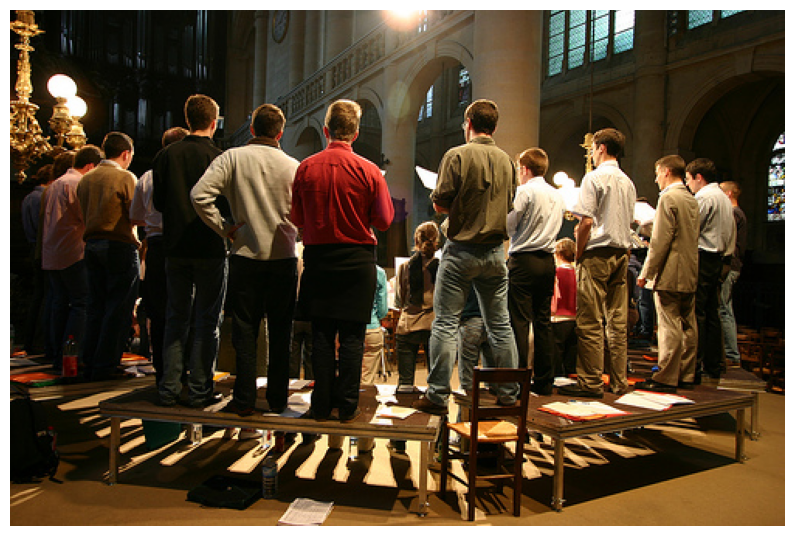

Generated Caption: disrupted disrupted disrupted disrupted disrupted disrupted disrupted disrupted disrupted disrupted disrupted disrupted disrupted iklaniklaniklaniklaniklaniklaniklaniklaniklaniklaniklaniklaniklaniklaniklaniklaniklaniklaniklan
Target Caption: Rear view of a choir group standing on risers with a chair filling a space between the risers.


In [87]:
import random
import torch
import matplotlib.pyplot as plt
from transformers import CLIPModel, CLIPProcessor, CLIPTokenizer

# Ensure device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Current device:', device)

# Example usage:
# Load models and processors
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Initialize decoder
embedding_dim = 512
num_heads = 8
mlp_dimension = 2048
num_layers = 2
vocab_size = 49408

decoder = Decoder(embedding_dim, num_heads, mlp_dimension, num_layers, vocab_size).to(device)

# Load trained weights if provided
# decoder = torch.load("decoder_08051505.pt", weights_only=False)

decoder.eval()
decoder = decoder.to(device)

# Get a random image from the test set
idx = random.randint(0, len(test) - 1)
sample = test[idx]
image = sample['image']
true_caption = sample['caption'][0]  # Get the first caption

# Define the generate_caption function
def generate_caption(embedding_dim, image, decoder, clip_model, clip_processor, tokenizer, device, max_length=32):
    # Process image through CLIP
    inputs = clip_processor(images=image, return_tensors="pt").to(device)
    
    with torch.no_grad():
        # Get image embeddings
        patch_embeddings = clip_model.vision_model(**inputs).last_hidden_state[:, 1:, :].squeeze(0)
        
        # Project image features
        image_projection_layer = torch.nn.Linear(patch_embeddings.shape[-1], embedding_dim).to(device)
        img_features = image_projection_layer(patch_embeddings)
        
        # Add batch dimension to img_features
        img_features = img_features.unsqueeze(0)  # Shape: [1, num_patches, embedding_dim]
    
    # Initialize with start token
    start_token = tokenizer.encode("<|startoftext|>")[0]
    end_token = tokenizer.encode("<|endoftext|>")[0]
    
    generated_tokens = [start_token]
    
    # Generate tokens one by one
    for _ in range(max_length):
        # Convert generated tokens to tensor
        input_ids = torch.tensor([generated_tokens]).to(device)
        
        # Get text embeddings
        with torch.no_grad():
            text_embeddings = clip_model.text_model.embeddings(input_ids).squeeze(0)
            # Add batch dimension to text_embeddings
            text_embeddings = text_embeddings.unsqueeze(0)  # Shape: [1, seq_len, embedding_dim]
        
        # Get logits from decoder
        logits = decoder(text_embeddings, img_features)
        
        # Get next token (only look at the last position)
        next_token = logits[0, -1].argmax(dim=-1).item()

        generated_tokens.append(next_token)
        
        # Stop if we generate the end token
        if next_token == end_token:
            break
            
    # Decode the generated tokens to a caption
    generated_caption = tokenizer.decode(generated_tokens, skip_special_tokens=True)
    
    return generated_caption

# Generate caption using the trained decoder
generated_caption = generate_caption(embedding_dim, image, decoder, clip_model, clip_processor, tokenizer, device)

# Display image with both captions
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

# Print captions separately for better readability
print(f"Generated Caption: {generated_caption}")
print(f"Target Caption: {true_caption}")



### DUMP

In [ ]:
# captions produces a list of captions
#captions = [caption for caption_list[0] for caption_list in test['caption']]  

captions = []
for caption_list in test['caption']:
    for caption in caption_list[0]:
        captions.append(caption)



The change from total_loss and num_batches to epoch_losses = [] offers several advantages:
More Accurate Average:
With total_loss and num_batches, you're calculating a running average that might be affected by the order of batches
With epoch_losses, you store all individual losses and calculate the true average at the end, which is more accurate
More Information:
By storing all losses in a list, you can:
Calculate the median loss
Find the minimum and maximum losses
Plot the loss distribution
Detect outliers or unusual patterns
Calculate standard deviation
Debugging and Analysis:
If you notice something unusual in the average loss, you can look at the individual losses to understand what's happening
You can track how the loss changes throughout the epoch